### Stochastic Gradient Descent Simulations

Consider a binary classification problem for non-seperable, multivariate normal data. Write a program that generates training data of $n$ i.i.d. pairs of random variables with $X \in R^d$ and $Y \in \{-1,1 \}$, with $\mathbf{P}\{Y=1\}=1 / 2$, identity covariance matrix and class conditional mean vectors $(-a, 0,0, \dots, 0)$ and $(a, 0,0, \dots, 0)$.

Train a linear classifier by performing stochastic gradient-descent minimization of the function 

$$ f(w)=\mathbf{E} \phi\left(-w^{T} X Y\right) $$ 

where $\phi$ is an increasing convex function. Estimate the probability of error of the obtained classifier and compare it to the Bayes classifier. Try different choices of $a, n, d$ and thefunction $\phi$ such as $\phi(x)=(1+x)_{+}, \phi(x)=e^{x}, \phi(x)=\log _{2}\left(1+e^{x}\right)$. Further, play with the tuning parameter of the stochastic gradient descent algorithm.

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import seaborn as sns
import itertools
from multiprocessing import Pool
import matplotlib.pyplot as plt
from scipy.stats import norm

First, setting up the data generating process.

In [2]:
def generateData(n,d,m):
    
    m = np.array([m])
    
    # Mean vectors and covariance matrix
    mean_y_pos = np.concatenate((m,np.zeros(d-1)))
    mean_y_neg = np.concatenate((-m,np.zeros(d-1)))
    covariance = np.identity(d)

    # Generate Y values
    y = np.array([-1 if y < 0.5 else 1 for y in np.random.uniform(0,1,n)])

    # Sort, makes merging with x values easier
    y.sort()

    # Generating features 
    x_neg = np.random.multivariate_normal(mean_y_neg,covariance,sum(y==-1))
    x_pos = np.random.multivariate_normal(mean_y_pos,covariance,sum(y==1))

    # Merging together
    X = np.vstack((x_neg,x_pos))

    # Shuffle
    X, y = shuffle(X, y)


    return X, y

The classifier has the form $sign(w^TX)$. Consequently, we need to find the $w$ that minimizes a given loss function on our data. We define the following loss-classes each with respective scores and gradients:

In [3]:
# First we define the loss-function class
class HingeLoss:
    
    def __init__(self,d):
        self.d = d
        
    def score(self,prediction,y):
        # Note that prediction should be the output w @ X.T, not the sign
        return(sum(np.maximum(np.zeros(len(prediction)),1-prediction*y)))
    
    def gradient(self,weights,X,y):
        # Gradient for one observation, given data
        gradient = -X * y if -weights.T @ X * y < 1 else 0 
        return(np.array(gradient))
    
class ExpLoss:
    
    def __init__(self,d):
        self.d = d
        
    def score(self,prediction,y):
        # Note that prediction should be the output w @ X.T, not the sign
        return(np.sum(np.exp(-prediction*y)))
    
    def gradient(self,weights,X,y):
        # Gradient for one observation, given data
        gradient = (-X *y * np.exp(-weights @ X.T * y))
        return(np.array(gradient/np.linalg.norm(gradient)))
    
class LogLoss:    
    
    def __init__(self,d):
        self.d = d
        
    def score(self,prediction,y):
        # Note that prediction should be the output w @ X.T, not the sign
        return(np.sum(np.log(1+np.exp(-prediction* y))))
    
    def gradient(self,weights,X,y):
        # Gradient for one observation, given data
        gradient = - X* y * np.exp(-weights.T @ X* y) / (( 1+ np.exp(-weights.T @ X * y) * np.log(2) ))
        return(np.array(gradient))

Having defined the loss functions we can no write the optimizer:

In [5]:
def sgd(X,y,lossFunc,eta, epochs):
    
    d = X.shape[1]
    
    if lossFunc == "hinge":
        loss = HingeLoss(d)
    if lossFunc == "exp":
        loss = ExpLoss(d)
    if lossFunc == "log":
        loss = LogLoss(d)
    
    # Initialize weights and weight vector
    w = np.zeros(X.shape[1])
    
    w_hist = []
    
    # Generate random index (for shuffle)
    rand_indx = np.random.randint(len(y),size = epochs)
        
    # Go over data and update weights according to sgd rule
    for idx in rand_indx:
            
        # Get gradient
        current_gradient = loss.gradient(w, np.array(X[idx]), np.array(y[idx]))

        # Update
        w = w - eta * current_gradient

        # Store result
        w_hist.append(w)
    return(np.mean(w_hist,axis = 0))
            

Now that everything is set up, we can start simulating to estimate the empirical risk of classifiers based on the previously defined loss functions. We want to simulate for a wide range of $a$, $d$ and training sizes $n$. Further we'd like to experiment with the training rate $\eta$ and the number of epochs. 

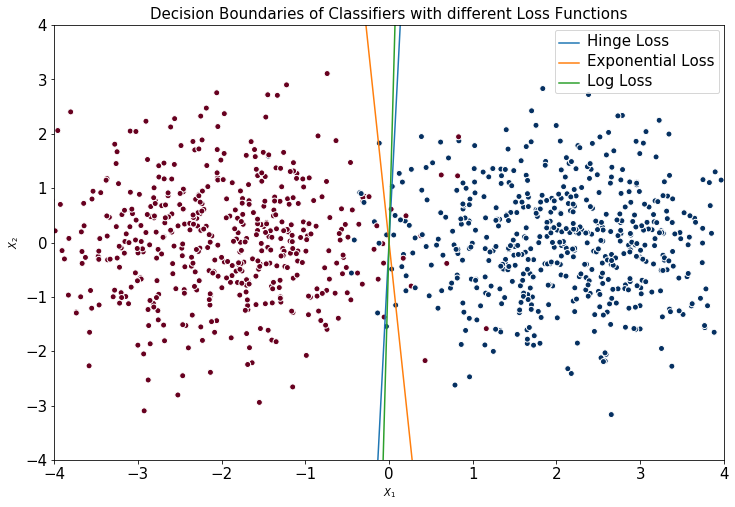

In [6]:
# Showing Classifiers in 2d

# Parameters
d = 2
n = 1000
a = 2
eta = 0.01
epochs = 500

# Generating Data
X, y = generateData(n,d,a)

# Fit all three types 
hinge_w = sgd(X,y,"hinge", eta, epochs)
exp_w = sgd(X,y,"exp", eta, epochs)
log_w = sgd(X,y,"log", eta, epochs)

# Plot
fig, ax = plt.subplots(figsize=(12,8))
    
# Scatter data points, color by class
ax.scatter(X[::,0], X[::, 1], c=y, cmap="RdBu",edgecolor="white", linewidth=1)    

# Set ax labels
ax.set(xlabel="$X_1$", ylabel="$X_2$")
ax.set_ylim(-4,4)
ax.set_xlim(-4,4)

# Add Classifiers
z = np.linspace(-2,2,100)
sns.lineplot(x= z, y = z*(-hinge_w[0]/hinge_w[1]), ax = ax, label ="Hinge Loss")
sns.lineplot(x= z, y = z*(-exp_w[0]/exp_w[1]), ax = ax, label ="Exponential Loss")
a = sns.lineplot(x= z, y = z*(-log_w[0]/log_w[1]), ax = ax, label ="Log Loss")

# Plot Params
ax.tick_params(labelsize=15)
ax.set_title(f'Decision Boundaries of Classifiers with different Loss Functions', fontsize = 15)
plt.setp(a.get_legend().get_texts(), fontsize='15');
#fig.savefig(f"../01_Figures/Decisions_Boundaries", dpi=80)

In [7]:
# Function for simulating for giving parameters
def simulate(n,d,epochs,eta,rounds, meanToEvaluate,testing_n):

    # Setting up result lists
    bayes_risk = [norm.cdf(0,loc = a, scale = 1 ) for a in meanToEvaluate]
    hinge_risk = []
    exp_risk = []
    log_risk = []
    
    # Simulate
    for a in meanToEvaluate:

        # Sett up temp vectors
        temp_hinge_risk = []
        temp_exp_risk = []
        temp_log_risk = []

        # Rounds
        for i in range(rounds):

            # Generate data 
            data_X, data_y = generateData(n+testing_n,d,a)

            training_X = data_X[0:n,:]
            training_y = data_y[0:n]
            testing_x = data_X[n:,:]
            testing_y = data_y[n:]

            # Fit the three classifiers
            hinge_w = sgd(training_X,training_y,"hinge", eta, epochs)
            exp_w = sgd(training_X,training_y,"exp", eta, epochs)
            log_w = sgd(training_X,training_y,"log", eta, epochs)

            # Score and save to temp
            temp_hinge_risk.append(1-accuracy_score(testing_y,np.sign(hinge_w @ testing_x.T)))
            temp_exp_risk.append(1-accuracy_score(testing_y,np.sign(exp_w @ testing_x.T)))
            temp_log_risk.append(1-accuracy_score(testing_y,np.sign(log_w @ testing_x.T)))

        # Save averages
        hinge_risk.append(np.mean(temp_hinge_risk))
        exp_risk.append(np.mean(temp_exp_risk))
        log_risk.append(np.mean(temp_log_risk))
    
    return(hinge_risk,exp_risk,log_risk,bayes_risk)
    

10 2
100 2
1000 2


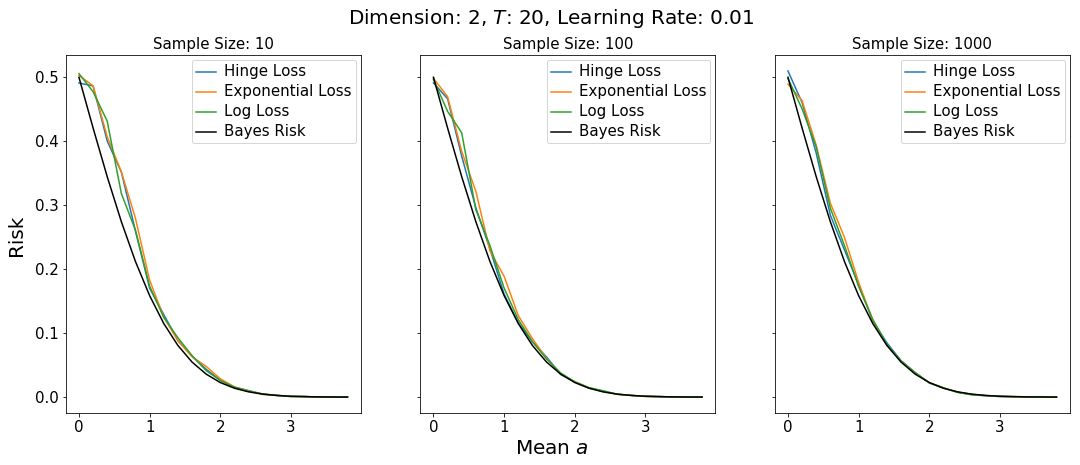

In [55]:
# Dimensions and sample sizes to evaluate
dimensions = [2]
sample_sizes = [10,100,1000]

# Standard params
# Simulating for range of as
meanToEvaluate = np.arange(0, 4, 0.2)
epochs = 20
eta = 0.01
rounds = 20
testing_n = 400

# Simulate
fig, ax = plt.subplots(nrows=1, ncols=3, figsize= (18,6.6), sharey= True)
i = 0
for (n,d) in list(itertools.product(sample_sizes, dimensions)):
    print(n,d)
    hinge_risk,exp_risk,log_risk,bayes_risk = simulate(n,d,epochs,eta,rounds, meanToEvaluate,testing_n)
    sns.lineplot(x= meanToEvaluate, y = hinge_risk, ax = ax[i], label ="Hinge Loss")
    sns.lineplot(x= meanToEvaluate, y = np.array(exp_risk), ax = ax[i], label ="Exponential Loss")
    sns.lineplot(x= meanToEvaluate, y = np.array(log_risk), ax = ax[i], label ="Log Loss")
    a = sns.lineplot(x= meanToEvaluate, y = np.array(bayes_risk), ax = ax[i], label ="Bayes Risk", color ="black")
    ax[i].tick_params(labelsize=15)
    ax[i].set_title(f'Sample Size: {n}', fontsize = 15)
    i += 1
    plt.setp(a.get_legend().get_texts(), fontsize='15')

fig.text(0.5, 0.04, 'Mean $a$', ha='center', fontsize=20)
fig.text(0.08, 0.5, 'Risk', va='center', rotation='vertical', fontsize=20)
fig.suptitle(f"Dimension: {d}, $T$: {epochs}, Learning Rate: {eta}",fontsize = 20);
fig.savefig(f"../01_Figures/Risk_Dimension_{d}", dpi=80)

10 100
100 100
1000 100


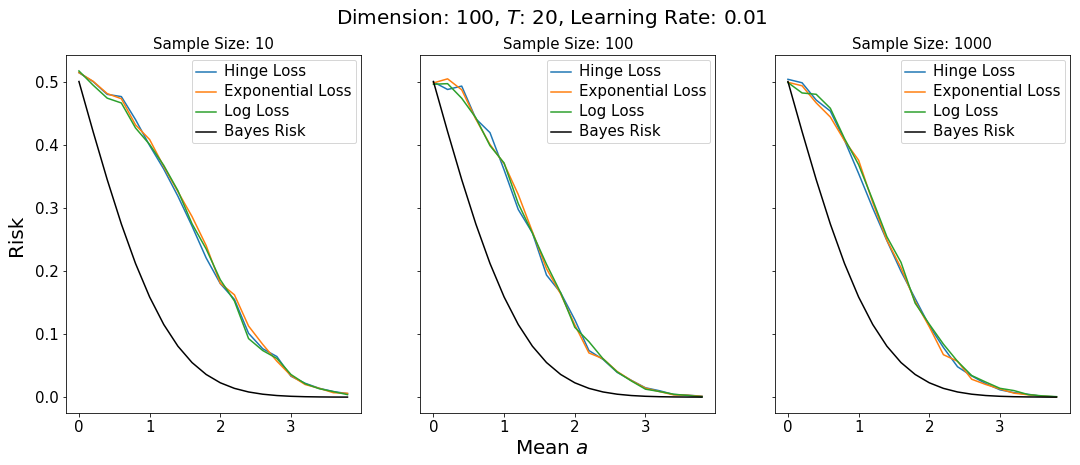

In [56]:
# Dimensions and sample sizes to evaluate
dimensions = [100]
sample_sizes = [10,100,1000]

# Standard params
# Simulating for range of as
meanToEvaluate = np.arange(0, 4, 0.2)
epochs = 20
eta = 0.01
rounds = 20
testing_n = 400

# Simulate
fig, ax = plt.subplots(nrows=1, ncols=3, figsize= (18,6.6), sharey= True)
i = 0
for (n,d) in list(itertools.product(sample_sizes, dimensions)):
    print(n,d)
    hinge_risk,exp_risk,log_risk,bayes_risk = simulate(n,d,epochs,eta,rounds, meanToEvaluate,testing_n)
    sns.lineplot(x= meanToEvaluate, y = hinge_risk, ax = ax[i], label ="Hinge Loss")
    sns.lineplot(x= meanToEvaluate, y = np.array(exp_risk), ax = ax[i], label ="Exponential Loss")
    sns.lineplot(x= meanToEvaluate, y = np.array(log_risk), ax = ax[i], label ="Log Loss")
    a = sns.lineplot(x= meanToEvaluate, y = np.array(bayes_risk), ax = ax[i], label ="Bayes Risk", color ="black")
    ax[i].tick_params(labelsize=15)
    ax[i].set_title(f'Sample Size: {n}', fontsize = 15)
    i += 1
    plt.setp(a.get_legend().get_texts(), fontsize='15')

fig.text(0.5, 0.04, 'Mean $a$', ha='center', fontsize=20)
fig.text(0.08, 0.5, 'Risk', va='center', rotation='vertical', fontsize=20)
fig.suptitle(f"Dimension: {d}, $T$: {epochs}, Learning Rate: {eta}",fontsize = 20);
fig.savefig(f"../01_Figures/Risk_Dimension_{d}", dpi=80)

10 1000
100 1000
1000 1000


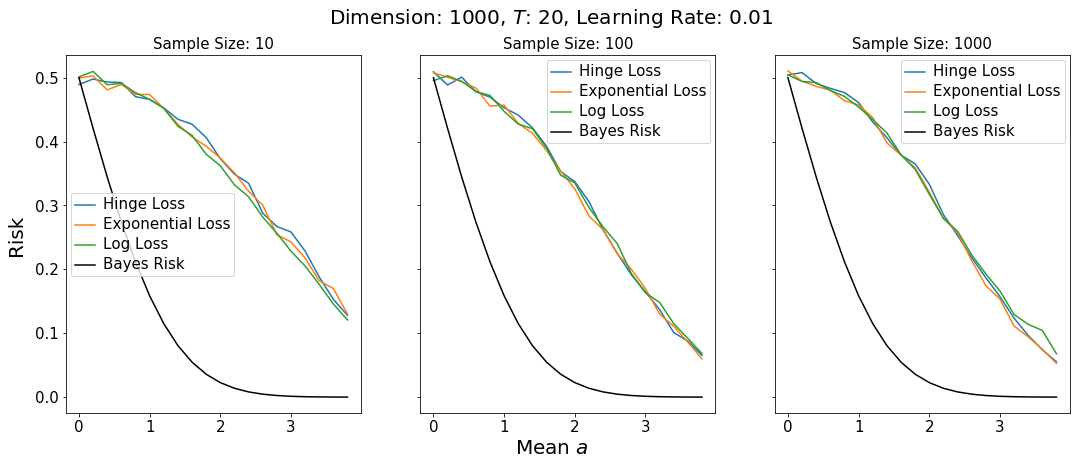

In [72]:
# Dimensions and sample sizes to evaluate
dimensions = [1000]
sample_sizes = [10,100,1000]

# Standard params
# Simulating for range of as
meanToEvaluate = np.arange(0, 4, 0.2)
epochs = 20
eta = 0.01
rounds = 20
testing_n = 400

# Simulate
fig, ax = plt.subplots(nrows=1, ncols=3, figsize= (18,6.6), sharey= True)
i = 0
for (n,d) in list(itertools.product(sample_sizes, dimensions)):
    print(n,d)
    hinge_risk,exp_risk,log_risk,bayes_risk = simulate(n,d,epochs,eta,rounds, meanToEvaluate,testing_n)
    sns.lineplot(x= meanToEvaluate, y = hinge_risk, ax = ax[i], label ="Hinge Loss")
    sns.lineplot(x= meanToEvaluate, y = np.array(exp_risk), ax = ax[i], label ="Exponential Loss")
    sns.lineplot(x= meanToEvaluate, y = np.array(log_risk), ax = ax[i], label ="Log Loss")
    a = sns.lineplot(x= meanToEvaluate, y = np.array(bayes_risk), ax = ax[i], label ="Bayes Risk", color ="black")
    ax[i].tick_params(labelsize=15)
    ax[i].set_title(f'Sample Size: {n}', fontsize = 15)
    i += 1
    plt.setp(a.get_legend().get_texts(), fontsize='15')

fig.text(0.5, 0.04, 'Mean $a$', ha='center', fontsize=20)
fig.text(0.08, 0.5, 'Risk', va='center', rotation='vertical', fontsize=20)
fig.suptitle(f"Dimension: {d}, $T$: {epochs}, Learning Rate: {eta}",fontsize = 20);
fig.savefig(f"../01_Figures/Risk_Dimension_{d}", dpi=80)

Finally, plot performance depending on different learning rates and epochs, starting with learning rates.

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500


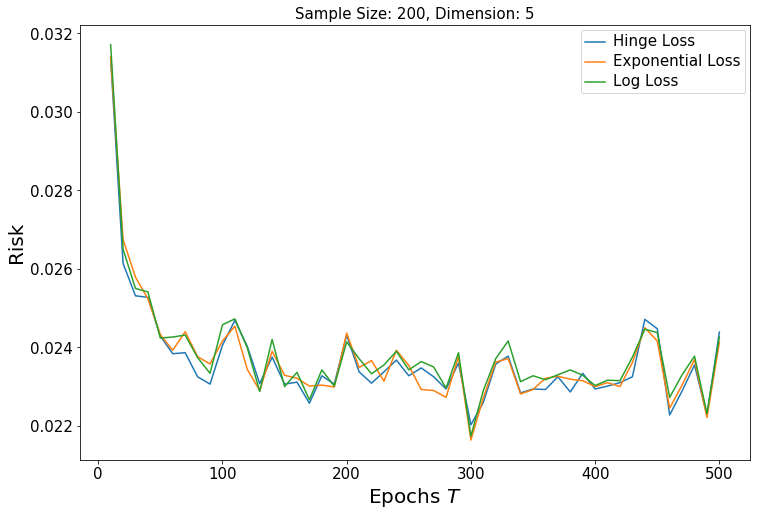

In [9]:
# Dimensions and sample sizes to evaluate
d = 5
n = 200

# Standard params
a = 2
eta = 0.01
rounds = 200
testing_n = 400

# Epochs to simulate
epochs = np.arange(10,510,10)


hinge_risk = []
exp_risk = []
log_risk = []

# Simulate
for eps in epochs:
    print(eps)

    # Sett up temp vectors
    temp_hinge_risk = []
    temp_exp_risk = []
    temp_log_risk = []

    # Rounds
    for i in range(rounds):

        # Generate data 
        data_X, data_y = generateData(n+testing_n,d,a)

        training_X = data_X[0:n,:]
        training_y = data_y[0:n]
        testing_x = data_X[n:,:]
        testing_y = data_y[n:]

        # Fit the three classifiers
        hinge_w = sgd(training_X,training_y,"hinge", eta, eps)
        exp_w = sgd(training_X,training_y,"exp", eta, eps)
        log_w = sgd(training_X,training_y,"log", eta, eps)

        # Score and save to temp
        temp_hinge_risk.append(1-accuracy_score(testing_y,np.sign(hinge_w @ testing_x.T)))
        temp_exp_risk.append(1-accuracy_score(testing_y,np.sign(exp_w @ testing_x.T)))
        temp_log_risk.append(1-accuracy_score(testing_y,np.sign(log_w @ testing_x.T)))

    # Save averages
    hinge_risk.append(np.mean(temp_hinge_risk))
    exp_risk.append(np.mean(temp_exp_risk))
    log_risk.append(np.mean(temp_log_risk))
    
#Plot
fig, ax = plt.subplots(figsize=(12,8))

sns.lineplot(x= epochs, y = hinge_risk, ax = ax, label ="Hinge Loss")
sns.lineplot(x= epochs, y = np.array(exp_risk), ax = ax, label ="Exponential Loss")
sns.lineplot(x= epochs, y = np.array(log_risk), ax = ax, label ="Log Loss")
ax.tick_params(labelsize=15)
ax.set_title(f'Sample Size: {n}, Dimension: {d}', fontsize = 15)
# Set ax labels
ax.set_xlabel("Epochs $T$", fontsize  =20)
ax.set_ylabel("Risk", fontsize  =20)

plt.setp(ax.get_legend().get_texts(), fontsize='15');
fig.savefig(f"../01_Figures/Epochs", dpi=80)

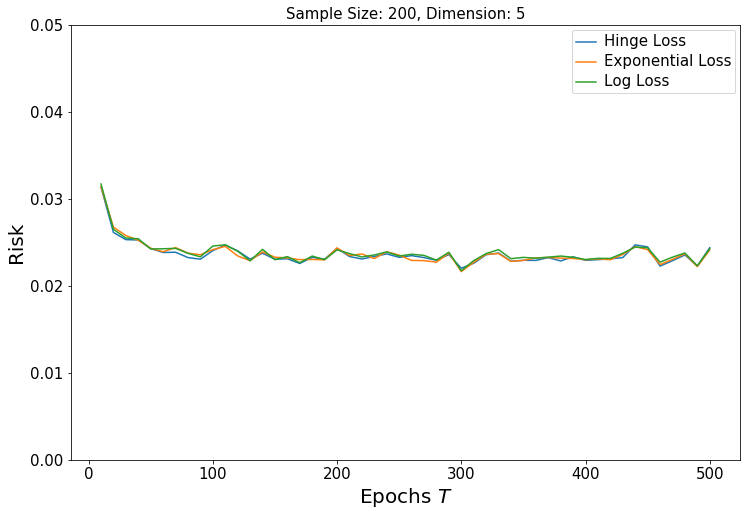

In [12]:
#Plot
fig, ax = plt.subplots(figsize=(12,8))

sns.lineplot(x= epochs, y = hinge_risk, ax = ax, label ="Hinge Loss")
sns.lineplot(x= epochs, y = np.array(exp_risk), ax = ax, label ="Exponential Loss")
sns.lineplot(x= epochs, y = np.array(log_risk), ax = ax, label ="Log Loss")
ax.tick_params(labelsize=15)
ax.set_title(f'Sample Size: {n}, Dimension: {d}', fontsize = 15)
# Set ax labels
ax.set_ylim(bottom=0,top= 0.05)
ax.set_xlabel("Epochs $T$", fontsize  =20)
ax.set_ylabel("Risk", fontsize  =20)

plt.setp(ax.get_legend().get_texts(), fontsize='15');
fig.savefig(f"../01_Figures/Epochs", dpi=80)

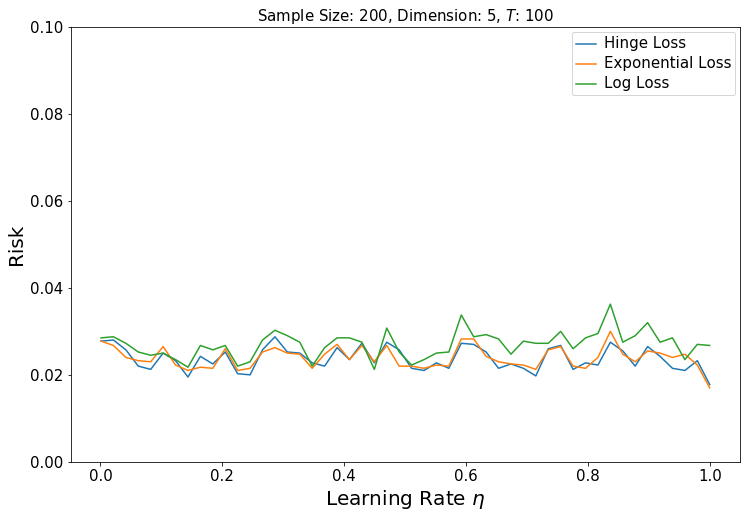

In [8]:
# Dimensions and sample sizes to evaluate
d = 5
n = 200

# Standard params
a = 2

eps = 100
rounds = 10
testing_n = 400

# Learning rate to simulate
learningRates = np.linspace(0.001,1)

hinge_risk = []
exp_risk = []
log_risk = []

# Simulate
for eta in learningRates:

    # Sett up temp vectors
    temp_hinge_risk = []
    temp_exp_risk = []
    temp_log_risk = []

    # Rounds
    for i in range(rounds):

        # Generate data 
        data_X, data_y = generateData(n+testing_n,d,a)

        training_X = data_X[0:n,:]
        training_y = data_y[0:n]
        testing_x = data_X[n:,:]
        testing_y = data_y[n:]

        # Fit the three classifiers
        hinge_w = sgd(training_X,training_y,"hinge", eta, eps)
        exp_w = sgd(training_X,training_y,"exp", eta, eps)
        log_w = sgd(training_X,training_y,"log", eta, eps)

        # Score and save to temp
        temp_hinge_risk.append(1-accuracy_score(testing_y,np.sign(hinge_w @ testing_x.T)))
        temp_exp_risk.append(1-accuracy_score(testing_y,np.sign(exp_w @ testing_x.T)))
        temp_log_risk.append(1-accuracy_score(testing_y,np.sign(log_w @ testing_x.T)))

    # Save averages
    hinge_risk.append(np.mean(temp_hinge_risk))
    exp_risk.append(np.mean(temp_exp_risk))
    log_risk.append(np.mean(temp_log_risk))
    
#Plot
fig, ax = plt.subplots(figsize=(12,8))

sns.lineplot(x= learningRates, y = hinge_risk, ax = ax, label ="Hinge Loss")
sns.lineplot(x= learningRates, y = np.array(exp_risk), ax = ax, label ="Exponential Loss")
sns.lineplot(x= learningRates, y = np.array(log_risk), ax = ax, label ="Log Loss")
ax.tick_params(labelsize=15)
ax.set_title(f'Sample Size: {n}, Dimension: {d}, $T$: {eps}', fontsize = 15)
ax.set_ylim(bottom=0,top= 0.1)
# Set ax labels
ax.set_xlabel("Learning Rate $\eta$", fontsize  =20)
ax.set_ylabel("Risk", fontsize  =20)

plt.setp(ax.get_legend().get_texts(), fontsize='15');
fig.savefig(f"../01_Figures/LearningRate", dpi=80)